# MNIST Digit Classification Model using CNN
Reference: https://github.com/boaaaang/CNN-Implementation-in-Verilog

## 1. Model Development
Create and train the CNN model for MNIST digit classification.

In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy as np
from matplotlib import pyplot

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# MNIST Dataset
train_dataset = datasets.MNIST(root='./data/',
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)
test_dataset = datasets.MNIST(root='./data/',
                              train=False,
                              transform=transforms.ToTensor())

In [4]:
# Data Loader (Input Pipeline)
batch_size = 64
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [5]:
# CNN class
class CNN(nn.Module):
     # Initialization
    def __init__(self):
        super (CNN, self).__init__()
        
        self.conv1_out_np = np.zeros((1, 3, 24, 24))
        self.mp1_out_np = np.zeros((1, 3, 12, 12))
        self.conv2_out_np = np.zeros((1, 3, 8, 8))
        self.mp2_out_np = np.zeros((1, 3, 4, 4))
        self.fc_in_np = np.zeros((1, 48))
        self.fc_out_np = np.zeros((1, 10))
        
        # 1st Convolution Layer
        # Image Input Shape -> (28, 28, 1)
        # Convolution Layer -> (24, 24, 3)
        # Pooling Max Layer -> (12, 12, 3)
        self.conv1 = nn.Conv2d(1, 3, kernel_size=5)
        
        # 2nd Convolution Layer
        # Image Input Shape -> (12, 12, 3)
        # Convolution Layer -> (8, 8, 3)
        # pooling Max Layer -> (4, 4, 3)
        self.conv2 = nn.Conv2d(3, 3, kernel_size=5)
        
        # Max Pooling Layer
        self.mp = nn.MaxPool2d(2)
        
        # Fully Connected Layer
        # Num of Weight = 480
        self.fc_1 = nn.Linear(48, 10)
        
    def forward(self, x):
        in_size = x.size(0)
        
        # Layer Integration
        x = self.conv1(x)
        self.conv1_out_np = x.detach().numpy()
        
        x = F.relu(self.mp(x))
        self.mp1_out_np = x.detach().numpy()

        x = self.conv2(x)
        self.conv2_out_np = x.detach().numpy()
        
        x = F.relu(self.mp(x))
        self.mp2_out_np = x.detach().numpy()
        
        # Flatten Layer
        x = x.view(in_size, -1)
        self.fc_in_np = x.detach().numpy()
        
        # Fully Connected Layer
        x = self.fc_1(x)
        self.fc_out_np = x.detach().numpy()
        
        return F.log_softmax(x)

In [6]:
# Instantiation
model = CNN()
print(model)

CNN(
  (conv1): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(3, 3, kernel_size=(5, 5), stride=(1, 1))
  (mp): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_1): Linear(in_features=48, out_features=10, bias=True)
)


In [7]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 796


In [8]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [9]:
# Training
def train(epoch):
    model.train()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        
        optimizer.zero_grad()
        
        # Ouput of feedforwarding
        output = model(data)
        
        # Loss calibration
        loss = F.nll_loss(output, target)
        
        # Gradient
        loss.backward()
        
        # Back propagation
        optimizer.step()
        
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [10]:
# Test
def test():
    model.eval()

    test_loss = 0
    correct = 0
    
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        
        # Output of feedforwarding
        output = model(data)
        
        test_loss += F.nll_loss(output, target, size_average=False).item()
        
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
          
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [11]:
# Traning process
for epoch in range(1, 10):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.301875
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.283728
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.285463
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.282386
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.308233
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.258116
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.266397
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.266261
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.236049
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.246225
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.206519
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.186950
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.152501
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.141190
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.067386
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.970310
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.876815
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.743825
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.540556
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.393882
Train Epoch: 1 [12800/60000 (

## 2. Save Trained Weight and Bias
Save trained weight and bias to a .pt file.

In [12]:
# Save model
torch.save(model, "./cnn_mnist.pt")

In [13]:
# Load model
model = torch.load("./cnn_mnist.pt", weights_only=False)
model.eval()
print(model)

CNN(
  (conv1): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(3, 3, kernel_size=(5, 5), stride=(1, 1))
  (mp): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_1): Linear(in_features=48, out_features=10, bias=True)
)


In [14]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 796


## 3. Testing using Bitmap Image
Test the model to classify a digit from .bmp image.

In [15]:
from PIL import Image

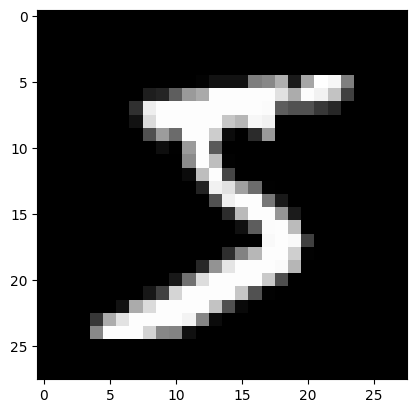

In [16]:
# Load bitmap image
img = Image.open("./bmp/train_0.bmp", "r")
np_img = np.array(img)
pyplot.imshow(np_img, cmap=pyplot.get_cmap('gray'))

In [17]:
np_img_re = np.reshape(np_img, (1,1,28,28))
# 0 - 255 => 0 - 1 로 정규화, np.array => tensor 변환
data = Variable(torch.tensor((np_img_re / 255), dtype = torch.float32))
    
# Output of feedforwarding
output = model(data)
pred = output.data.max(1, keepdim=True)[1]
print('Predicted output: ' + ', '.join(map(str, pred.flatten().tolist())))

Predicted output: 5


## 4. Extract Weight and Bias
Extract weight and bias to .mem files for RTL development.

In [18]:
#################### Weight & Bias in HEX of Convolution Layer1 ####################

# Calibration
int_conv1_weight_1 = torch.tensor((model.conv1.weight.data[0][0] * 128), dtype = torch.int32)
int_conv1_weight_2 = torch.tensor((model.conv1.weight.data[1][0] * 128), dtype = torch.int32)
int_conv1_weight_3 = torch.tensor((model.conv1.weight.data[2][0] * 128), dtype = torch.int32)
int_conv1_bias = torch.tensor((model.conv1.bias.data * 128), dtype = torch.int32)

print("Signed")
print(int_conv1_weight_1)
print(int_conv1_weight_2)
print(int_conv1_weight_3)
print(int_conv1_bias)

# 2's Complement
for i in range(5):
    for j in range(5):
        if int_conv1_weight_1[i][j] < 0:
            int_conv1_weight_1[i][j] += 256
        if int_conv1_weight_2[i][j] < 0:
            int_conv1_weight_2[i][j] += 256
        if int_conv1_weight_3[i][j] < 0:
            int_conv1_weight_3[i][j] += 256

for k in range(3):
    if int_conv1_bias[k] < 0:
        int_conv1_bias[k] += 256

print ("Unsigned")
print(int_conv1_weight_1)
print(int_conv1_weight_2)
print(int_conv1_weight_3)
print(int_conv1_bias)

np.savetxt('conv1_weight_1.mem', int_conv1_weight_1, fmt='%1.2x',delimiter = " ")
np.savetxt('conv1_weight_2.mem', int_conv1_weight_2, fmt='%1.2x',delimiter = " ")
np.savetxt('conv1_weight_3.mem', int_conv1_weight_3, fmt='%1.2x',delimiter = " ")
np.savetxt('conv1_bias.mem', int_conv1_bias, fmt='%1.2x',delimiter = " ")

Signed
tensor([[ 28, -31, -27, -40,  -6],
        [ 40,  72,  31,  59,  74],
        [ 66,  68, 102,  95,  67],
        [  4,  43,  42,  48,  45],
        [ -2, -10, -57, -32,  -5]], dtype=torch.int32)
tensor([[ 22, -16,  11,  42,  23],
        [-10,  -2,  38,  63,  23],
        [ 34,  45,  55,  56,  19],
        [ 36,  10,  -8,  10,  29],
        [ 31,  28,   0,  14,  52]], dtype=torch.int32)
tensor([[-50, -27,  14,  47,  56],
        [-69, -14,  20,  47,  20],
        [-51, -38,  30,  66,  39],
        [-36,   6,  32,  63,  33],
        [-34,   4,  38,  58,  23]], dtype=torch.int32)
tensor([ 10,  -1, -36], dtype=torch.int32)
Unsigned
tensor([[ 28, 225, 229, 216, 250],
        [ 40,  72,  31,  59,  74],
        [ 66,  68, 102,  95,  67],
        [  4,  43,  42,  48,  45],
        [254, 246, 199, 224, 251]], dtype=torch.int32)
tensor([[ 22, 240,  11,  42,  23],
        [246, 254,  38,  63,  23],
        [ 34,  45,  55,  56,  19],
        [ 36,  10, 248,  10,  29],
        [ 31,  28,   

In [19]:
#################### Weight & Bias in HEX of Convolution Layer2 ####################

# Calibration
# print(np.shape(model.conv2.weight))
int_conv2_weight_11 = torch.tensor((model.conv2.weight.data[0][0]* 128), dtype = torch.int32)
int_conv2_weight_12 = torch.tensor((model.conv2.weight.data[0][1]* 128), dtype = torch.int32)
int_conv2_weight_13 = torch.tensor((model.conv2.weight.data[0][2]* 128), dtype = torch.int32)

int_conv2_weight_21 = torch.tensor((model.conv2.weight.data[1][0] * 128), dtype = torch.int32)
int_conv2_weight_22 = torch.tensor((model.conv2.weight.data[1][1] * 128), dtype = torch.int32)
int_conv2_weight_23 = torch.tensor((model.conv2.weight.data[1][2] * 128), dtype = torch.int32)

int_conv2_weight_31 = torch.tensor((model.conv2.weight.data[2][0] * 128), dtype = torch.int32)
int_conv2_weight_32 = torch.tensor((model.conv2.weight.data[2][1] * 128), dtype = torch.int32)
int_conv2_weight_33 = torch.tensor((model.conv2.weight.data[2][2] * 128), dtype = torch.int32)

int_conv2_bias = torch.tensor((model.conv2.bias.data * 128), dtype = torch.int32)

print ("Signed")
print(int_conv2_weight_11)
print(int_conv2_weight_12)
print(int_conv2_weight_13, '\n')

print(int_conv2_weight_21)
print(int_conv2_weight_22)
print(int_conv2_weight_23, '\n')

print(int_conv2_weight_31)
print(int_conv2_weight_32)
print(int_conv2_weight_33, '\n')

print(int_conv2_bias)

# 2's Complement
for i in range(5):
    for j in range(5):
        if int_conv2_weight_11[i][j] < 0:
            int_conv2_weight_11[i][j] += 256
        if int_conv2_weight_12[i][j] < 0:
            int_conv2_weight_12[i][j] += 256
        if int_conv2_weight_13[i][j] < 0:
            int_conv2_weight_13[i][j] += 256
            
        if int_conv2_weight_21[i][j] < 0:
            int_conv2_weight_21[i][j] += 256
        if int_conv2_weight_22[i][j] < 0:
            int_conv2_weight_22[i][j] += 256
        if int_conv2_weight_23[i][j] < 0:
            int_conv2_weight_23[i][j] += 256
            
        if int_conv2_weight_31[i][j] < 0:
            int_conv2_weight_31[i][j] += 256
        if int_conv2_weight_32[i][j] < 0:
            int_conv2_weight_32[i][j] += 256
        if int_conv2_weight_33[i][j] < 0:
            int_conv2_weight_33[i][j] += 256

for k in range(3):
    if int_conv2_bias[k] < 0:
        int_conv2_bias[k] += 256

print ("Unsigned")
print(int_conv2_weight_11)
print(int_conv2_weight_12)
print(int_conv2_weight_13, '\n')

print(int_conv2_weight_21)
print(int_conv2_weight_22)
print(int_conv2_weight_23, '\n')

print(int_conv2_weight_31)
print(int_conv2_weight_32)
print(int_conv2_weight_33, '\n')

print(int_conv2_bias)

np.savetxt('conv2_weight_11.mem', int_conv2_weight_11, fmt='%1.2x',delimiter = " ")
np.savetxt('conv2_weight_12.mem', int_conv2_weight_12, fmt='%1.2x',delimiter = " ")
np.savetxt('conv2_weight_13.mem', int_conv2_weight_13, fmt='%1.2x',delimiter = " ")

np.savetxt('conv2_weight_21.mem', int_conv2_weight_21, fmt='%1.2x',delimiter = " ")
np.savetxt('conv2_weight_22.mem', int_conv2_weight_22, fmt='%1.2x',delimiter = " ")
np.savetxt('conv2_weight_23.mem', int_conv2_weight_23, fmt='%1.2x',delimiter = " ")

np.savetxt('conv2_weight_31.mem', int_conv2_weight_31, fmt='%1.2x',delimiter = " ")
np.savetxt('conv2_weight_32.mem', int_conv2_weight_32, fmt='%1.2x',delimiter = " ")
np.savetxt('conv2_weight_33.mem', int_conv2_weight_33, fmt='%1.2x',delimiter = " ")

np.savetxt('conv2_bias.mem', int_conv2_bias, fmt='%1.2x',delimiter = " ")

Signed
tensor([[-17,  41,  36,  21,  22],
        [ 11,  30,  25, -22,  -7],
        [  6,   6, -36, -46, -11],
        [  1, -29, -20,   1, -26],
        [-56, -10,  -2,   6, -28]], dtype=torch.int32)
tensor([[  0,  26,  36,  20,   7],
        [  6,  18,  16,  -6,   1],
        [ 28,   9, -19, -34,  -8],
        [ -1, -27, -14,   3,  -5],
        [-11, -11, -13, -12, -24]], dtype=torch.int32)
tensor([[  9,  29,  17,  -9,  -1],
        [ 34,  46,   5,  -7,  -6],
        [ 48,  30, -24, -42, -11],
        [ 43,   0, -16, -28, -25],
        [ 16,   8,   1,  -3, -21]], dtype=torch.int32) 

tensor([[  0,  24,  44,  46,  57],
        [ -2,  68,  99,  78,  51],
        [-37, -67, -73, -44,   3],
        [ 23,  11,   5, -15, -11],
        [  3,  36,  16,   9,  -3]], dtype=torch.int32)
tensor([[-10, -13,   7,   0,  40],
        [-12,  20,   2,   3,  19],
        [-36, -53, -49, -41,   6],
        [ -9, -23, -11, -10,  11],
        [ 15,  46,  43,  32,  -7]], dtype=torch.int32)
tensor([[  0,  1

In [20]:
#################### Weight & Bias in HEX of Fully Connected Layer ####################

print(np.shape(model.fc_1.weight))
print((model.fc_1.weight * 128).int())

print(np.shape(model.fc_1.bias))
print((model.fc_1.bias * 128).int())

int_fc_weight = (model.fc_1.weight * 128).int()
int_fc_bias = (model.fc_1.bias * 128).int()

# 2's Complement
for i in range(10):
    for j in range(48):
        if int_fc_weight[i][j] < 0 :
            int_fc_weight[i][j] += 256
    if int_fc_bias[i] < 0 :
        int_fc_bias[i] += 256
        
print(int_fc_weight)
print(int_fc_bias)

np.savetxt('fc_weight.mem', int_fc_weight, fmt='%1.2x',delimiter = " ")
np.savetxt('fc_bias.mem', int_fc_bias, fmt='%1.2x',delimiter = " ")

torch.Size([10, 48])
tensor([[ -2,   4,   5, -15,  11,  12,  21,  -7,  15,  14, -45,   0,   6,   6,
          -4,  29, -17,  14,   7,  -7, -43,   1,  32, -16, -46, -13,  -7, -12,
          -5, -23,  -5,  17,  27,   4,   0,  42,   2, -21, -21, -13,   4,  41,
          45, -45,   8,  57,  -8, -23],
        [  7,   7,  51,  13,  21,   7,  34,   0,  15,  13,  33,  13,  16,  12,
          30, -31,  32, -29, -24, -29,  -1, -15, -37, -46,  -4, -11, -27, -11,
         -20,   1, -21,  10,   7,  19,   0, -35,  24, -39, -30,  30,  47, -41,
          37,  35,  10,  -5,  20,  -6],
        [  6, -15, -12, -12,  -3,   5,  -9, -33,   9,   3,  -4,  35,  49,  33,
           8, -14,  35,  20,  17,  -4,  51,  22,  11, -41,   2,   3,  -8,   5,
         -37,  -6, -28,  68,  10, -22, -29,  -8,  -6, -18, -17,   0, -18,  21,
          51,  41,  14,  31,  -2,   9],
        [-17, -47,  -7,  -7,  10,  -5, -21,  31, -23,   0,  13,  -6, -32, -24,
         -23,   0,  45,  19,  18, -11,  59,   8,  18, -10,  21,   9, 